In [27]:
import json
import os
import shutil

for root, dirs, files in os.walk('../exp_results/baseline_sampled'):
    if any('checkpoint_00' in d for d in dirs):
        if not any('checkpoint_000110' in d for d in dirs) and not any('checkpoint_000055' in d for d in dirs):
            shutil.rmtree(root)


In [107]:
import json
import os
import re
import numpy as np
import pandas as pd

root_dir = '../exp_results/baseline_correct'

def load_eval_results(path):
    eval_results = []
    with open(path, 'r') as f:
        for line in f:
            data = json.loads(line)
            if 'evaluation' in data:
                eval_results.append(data['evaluation'])

    if len(eval_results) == 0:
        print(path)
    return eval_results

results = []
for alg_name in os.listdir(root_dir):
    for exp_name in os.listdir(os.path.join(root_dir, alg_name)):
        seed = int(re.findall('seed=([0-9]+)', exp_name)[0])
        for result_dir in os.listdir(os.path.join(root_dir, alg_name, exp_name)):
            if 'steps' in result_dir:
                sequence_len = int(re.findall('steps=([0-9]+)', result_dir)[0])
            elif 'days' in result_dir:
                sequence_len = int(re.findall('days=([0-9]+)', result_dir)[0]) * 1440
            else:
                continue

            for root, _, files in os.walk(os.path.join(root_dir, alg_name, exp_name, result_dir)):
                if 'result.json' in files:
                    eval_result = load_eval_results(os.path.join(root, 'result.json'))
                    best_result_id = np.argmax([r['episode_reward_mean'] for r in eval_result])
                    eval_result = eval_result[best_result_id]
                    results.append((alg_name, sequence_len, eval_result['episode_reward_mean'], eval_result['episode_reward_min'], eval_result['episode_reward_max'], seed))

df = pd.DataFrame(results, columns=['alg_name', 'seq_len', 'reward_mean','reward_min','reward_max', 'seed'])
df = df.sort_values(by=['alg_name', 'seq_len', 'seed'], ascending=[True, True, True])
df

,alg_name,seq_len,reward_mean,reward_min,reward_max,seed
134,DQN,5,3.312600,3.312600,3.312600,42
102,DQN,5,0.637288,0.637288,0.637288,52
126,DQN,10,23.910726,23.910726,23.910726,42
105,DQN,10,8.905038,8.905038,8.905038,52
120,DQN,30,33.127337,33.127337,33.127337,42
...,...,...,...,...,...,...
78,SAC,416160,1117.388326,157.543087,3494.897856,52
92,SAC,934560,504.510791,-357.254782,5096.483953,42
80,SAC,934560,1114.587539,138.008747,8214.056888,52
91,SAC,2102400,355.587685,-19.113031,791.332079,42


In [86]:
import numpy as np
from tqdm import tqdm

from rl_trading.simulation.env import StockExchangeEnv0
from rl_trading.data.indicators import *

state_config = {
        'market_state': ['vwap'],
        'technical_indicators': [
            (RPC, {}, '1min'),
            (EMA, dict(timeperiod=5, normalize=True), '1min'),
            (EMA, dict(timeperiod=13, normalize=True), '1min'),
            (RSI, dict(timeperiod=7, normalize=True), '1min'),
            (BBANDS, dict(timeperiod=10), '1min'),
            (EMA, dict(timeperiod=20, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1h'),
            (RSI, dict(timeperiod=14, normalize=True), '1h'),
            (BBANDS, dict(timeperiod=20), '1h'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1d'),
            (EMA, dict(timeperiod=200, normalize=True), '1d'),
            (RSI, dict(timeperiod=14, normalize=True), '1d'),
            (BBANDS, dict(timeperiod=20), '1d'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1d'),
        ]}

optimal_rewards = {}
for seed in df['seed'].unique():
    optimal_rewards[seed] = {}
    for seq_len in df['seq_len'].unique():
        max_steps = seq_len if seq_len < 1440 else 1440
        n_days = 1 if seq_len < 1440 else seq_len // 1440
        env = StockExchangeEnv0(sim_config={'max_steps': max_steps}, state_config=state_config, _n_days=n_days, seed=seed)

        rewards = []
        for start_idx in tqdm(env._idxs_range):
            env.reset()
            env.start_idx = start_idx
            done = False
            reward_total = 0
            while not done:
                current_idx = env.current_idx
                current_price = env.price_data['1min'][current_idx]
                next_price = env.price_data['1min'][current_idx + 1]
                if next_price > current_price:
                    action = 1
                elif next_price < current_price:
                    action = 2
                else:
                    action = 0
                state, reward, done, _, _ = env.step(action)
                reward_total += reward
            rewards.append(reward_total)
        print(f'Rewards for {seq_len} days: {np.mean(rewards)}')
        optimal_rewards[seed][seq_len] = np.mean(rewards)


print(optimal_rewards)

100%|██████████| 1/1 [00:00<00:00, 120.44it/s]


Rewards for 5 days: 3.312600487506643


100%|██████████| 1/1 [00:00<00:00, 83.38it/s]


Rewards for 10 days: 23.910725800918954


100%|██████████| 1/1 [00:00<00:00, 35.12it/s]


Rewards for 30 days: 43.69773366187292


100%|██████████| 1/1 [00:00<00:00, 20.45it/s]


Rewards for 60 days: 111.7008164300205


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


Rewards for 120 days: 206.08981530180426


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Rewards for 300 days: 631.5881569909507


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Rewards for 600 days: 1179.012786375477


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Rewards for 1440 days: 5162.891971480352


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Rewards for 2880 days: 4024.422951099774


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Rewards for 7200 days: 5394.111105234593


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Rewards for 15840 days: 6493.870153711446


100%|██████████| 25/25 [00:28<00:00,  1.12s/it]


Rewards for 36000 days: 5677.162602618677


100%|██████████| 57/57 [01:03<00:00,  1.11s/it]


Rewards for 82080 days: 8976.126213239351


100%|██████████| 128/128 [02:19<00:00,  1.09s/it]


Rewards for 184320 days: 5373.386521873657


100%|██████████| 289/289 [05:07<00:00,  1.07s/it]


Rewards for 416160 days: 5411.322828205352


100%|██████████| 649/649 [11:29<00:00,  1.06s/it]


Rewards for 934560 days: 6040.895608348617


100%|██████████| 1460/1460 [26:40<00:00,  1.10s/it]


Rewards for 2102400 days: 4744.421684233928


100%|██████████| 1/1 [00:00<00:00, 224.68it/s]


Rewards for 5 days: 0.6372875413107977


100%|██████████| 1/1 [00:00<00:00, 110.58it/s]


Rewards for 10 days: 8.905037992211874


100%|██████████| 1/1 [00:00<00:00, 41.14it/s]


Rewards for 30 days: 17.323385832361964


100%|██████████| 1/1 [00:00<00:00, 21.59it/s]


Rewards for 60 days: 47.56634807813134


100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


Rewards for 120 days: 104.1313420891056


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Rewards for 300 days: 377.37701697069315


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Rewards for 600 days: 968.7544803067467


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Rewards for 1440 days: 2425.516808528557


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Rewards for 2880 days: 5438.251660088126


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Rewards for 7200 days: 4509.026371463068


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Rewards for 15840 days: 5576.418833653713


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


Rewards for 36000 days: 5044.895301205964


100%|██████████| 57/57 [01:02<00:00,  1.10s/it]


Rewards for 82080 days: 4640.356128275012


100%|██████████| 128/128 [02:20<00:00,  1.10s/it]


Rewards for 184320 days: 4848.497688982672


100%|██████████| 289/289 [05:17<00:00,  1.10s/it]


Rewards for 416160 days: 5378.50928560913


100%|██████████| 649/649 [11:53<00:00,  1.10s/it]


Rewards for 934560 days: 5716.140278715971


100%|██████████| 1460/1460 [26:00<00:00,  1.07s/it]

Rewards for 2102400 days: 4725.212771055011
{42: {5: 3.312600487506643, 10: 23.910725800918954, 30: 43.69773366187292, 60: 111.7008164300205, 120: 206.08981530180426, 300: 631.5881569909507, 600: 1179.012786375477, 1440: 5162.891971480352, 2880: 4024.422951099774, 7200: 5394.111105234593, 15840: 6493.870153711446, 36000: 5677.162602618677, 82080: 8976.126213239351, 184320: 5373.386521873657, 416160: 5411.322828205352, 934560: 6040.895608348617, 2102400: 4744.421684233928}, 52: {5: 0.6372875413107977, 10: 8.905037992211874, 30: 17.323385832361964, 60: 47.56634807813134, 120: 104.1313420891056, 300: 377.37701697069315, 600: 968.7544803067467, 1440: 2425.516808528557, 2880: 5438.251660088126, 7200: 4509.026371463068, 15840: 5576.418833653713, 36000: 5044.895301205964, 82080: 4640.356128275012, 184320: 4848.497688982672, 416160: 5378.50928560913, 934560: 5716.140278715971, 2102400: 4725.212771055011}}


In [108]:
df['optimal_reward'] = np.nan

for row_idx, row in df.iterrows():
    df.loc[(df['seed'] == row['seed']) & (df['seq_len'] == row['seq_len']), 'optimal_reward'] = optimal_rewards[row['seed']][row['seq_len']]

In [109]:
df['adjusted_reward'] = df['reward_mean'] * 1440 / np.clip(df['seq_len'], 1, 1440)
df['normalized_reward'] = df['reward_mean'] / df['optimal_reward'] * 100

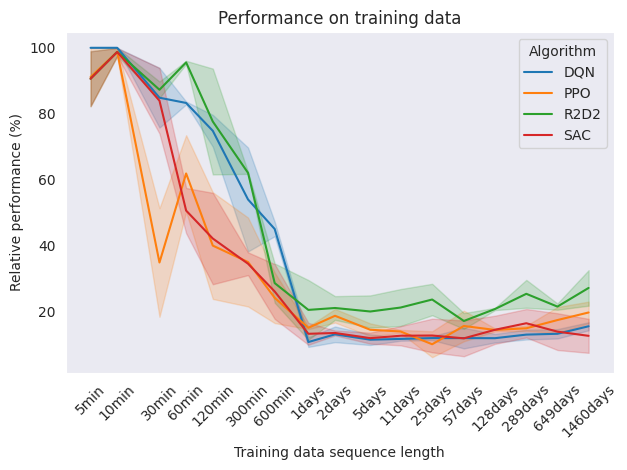

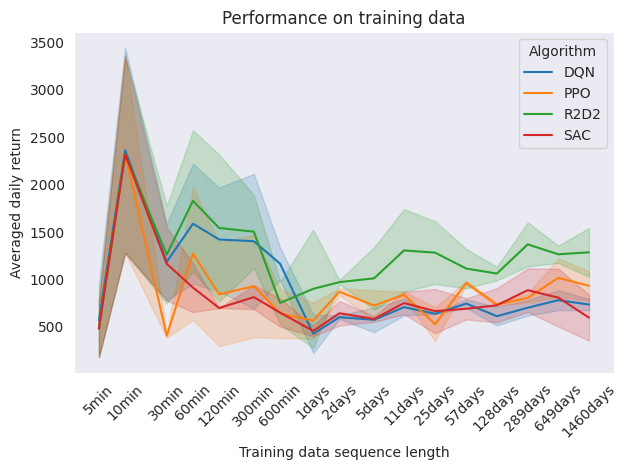

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x='seq_len', y='normalized_reward', hue='alg_name', data=df)
plt.xscale('log')
plt.xlabel('Training data sequence length')
plt.ylabel('Relative performance (%)')
plt.title('Performance on training data')
plt.legend(title='Algorithm')

ticks = [5, 10, 30, 60, 120, 300, 600] + (np.geomspace(1, 4 * 365, 10, dtype=int) * 1440).tolist()
labels = [f'{t}min' for t in [5, 10, 30, 60, 120, 300, 600]] + [f'{t}days' for t in np.geomspace(1, 4 * 365, 10, dtype=int)]
plt.xticks(ticks, labels, rotation=45)
plt.grid(False)
plt.tight_layout()
plt.savefig('benchmark_train_normalized.pdf')
plt.savefig('benchmark_train_normalized.png')
plt.show()

plt.close()

sns.lineplot(x='seq_len', y='adjusted_reward', hue='alg_name', data=df)
plt.xscale('log')
plt.xlabel('Training data sequence length')
plt.ylabel('Averaged daily return')
plt.title('Performance on training data')
plt.legend(title='Algorithm')

ticks = [5, 10, 30, 60, 120, 300, 600] + (np.geomspace(1, 4 * 365, 10, dtype=int) * 1440).tolist()
labels = [f'{t}min' for t in [5, 10, 30, 60, 120, 300, 600]] + [f'{t}days' for t in np.geomspace(1, 4 * 365, 10, dtype=int)]
plt.xticks(ticks, labels, rotation=45)
plt.grid(False)
plt.tight_layout()
plt.savefig('benchmark_train_adjusted.pdf')
plt.savefig('benchmark_train_adjusted.png')
plt.show()

In [120]:
df.to_csv('train_results.csv')

In [100]:
df['optimal_reward'] = np.nan

In [106]:


df

,alg_name,seq_len,reward_mean,reward_min,reward_max,seed,optimal_reward
134,DQN,5,100.000000,100.000000,100.000000,42,3.312600
102,DQN,5,100.000000,100.000000,100.000000,52,0.637288
126,DQN,10,100.000000,100.000000,100.000000,42,23.910726
105,DQN,10,100.000000,100.000000,100.000000,52,8.905038
120,DQN,30,75.810195,75.810195,75.810195,42,43.697734
...,...,...,...,...,...,...,...
78,SAC,416160,20.775056,2.929122,64.978931,52,5378.509286
92,SAC,934560,8.351589,-5.913937,84.366364,42,6040.895608
80,SAC,934560,19.498954,2.414369,143.699358,52,5716.140279
91,SAC,2102400,7.494858,-0.402853,16.679210,42,4744.421684
